### <u>SENTIMENT ANALYSIS OF DRUG REVIEWS USING ARTIFICIAL NEURAL NETWORKS </u>

### Introduction

NLP ( Natural language processing) is a sub-field of Artificial Intelligence and computational linguistic that focuses on the interaction between computer and human language.It involves a range of techniques and approaches to process and analyze text data. One such method is Sentiment analysis.

Sentiment Analysis, also known as opinion mining is the process of determining the sentiment or emotional tone behind the piece of text.It's goal is to classify the text into pre-defined sentiment categories, typically positive,negative or neutral.The increasing accessibility of online opinions has made this analysis an important tool to be used in personal or business developement.In this report ,we are going to perform sentiment analysis by using ANN ,on Drug reviews from two datasets, webmd and UCI machine learning repository.



In [ ]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import nltk

In [3]:
# loading dataset no: 1

df_webmd = pd.read_csv("C:/Users/Lithium/OneDrive/Documents/webmd.csv")
df_webmd.head(4)

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0


### Pre-Processing of datasets

The second dataset from UCI ML is divided in two parts ,so we will merge both parts with first dataset and
take out coulmns which are common to both datasets and required for our analysis. We also need to deal with rating column as one dataset contains rating from 1-5 and other contains from 1-10.Finally we will remove the rows with missing values.


In [4]:
# loading dataset no: 2(part: 1)
df_uci1=pd.read_csv("C:/Users/Lithium/OneDrive/Documents/drugsComTrain_raw.csv")
df_uci1=df_uci1[["uniqueID", "drugName", "review","rating"]]
df_uci1.head()

,uniqueID,drugName,review,rating
0,206461,Valsartan,"""It has no side effect, I take it in combinati...",9
1,95260,Guanfacine,"""My son is halfway through his fourth week of ...",8
2,92703,Lybrel,"""I used to take another oral contraceptive, wh...",5
3,138000,Ortho Evra,"""This is my first time using any form of birth...",8
4,35696,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9


In [5]:
# loading dataset no: 2(part: 2)
df_uci2=pd.read_csv("C:/Users/Lithium/OneDrive/Documents/drugsComTest_raw.csv")
df_uci2=df_uci2[["uniqueID", "drugName", "review","rating"]] 
df_uci2.head()


,uniqueID,drugName,review,rating
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",10
1,206473,Mesalamine,"""My son has Crohn&#039;s disease and has done ...",8
2,159672,Bactrim,"""Quick reduction of symptoms""",9
3,39293,Contrave,"""Contrave combines drugs that were used for al...",9
4,97768,Cyclafem 1 / 35,"""I have been on this birth control for one cyc...",9


In [6]:
#renaming columns in first dataframe to match with second
df_webmd = df_webmd.rename(columns={'Drug': 'drugName', 'DrugId': 'uniqueID', 'Reviews':'review',
                        'Satisfaction':'rating'})
df_webmd = df_webmd[["uniqueID", "drugName", "review","rating"]]
df_webmd['rating'] = df_webmd['rating'].apply(lambda x: x*2)
df_webmd.head()



,uniqueID,drugName,review,rating
0,146724,25dph-7.5peh,I'm a retired physician and of all the meds I ...,10
1,146724,25dph-7.5peh,cleared me right up even with my throat hurtin...,10
2,144731,warfarin (bulk) 100 % powder,why did my PTINR go from a normal of 2.5 to ov...,6
3,144731,warfarin (bulk) 100 % powder,FALLING AND DON'T REALISE IT,2
4,144731,warfarin (bulk) 100 % powder,My grandfather was prescribed this medication ...,2


In [7]:
#combining datasets

df=pd.concat([df_uci1,df_uci2,df_webmd])

df.dropna(inplace=True) # dropping rows with NA
df.shape


(577832, 4)


So our final dataset 'df' is ready for analysis. Its is a big dataset with over 5 hundred thousand rows(reviews) .However with wider range of samples,bias will reduce our ANN model can learn more diverse patterns and better capture the nuances of language,leading to improved accuracy. 

lets begin by finding the unique number of drugs contained in the dataset and check the number of reviews for each drug.


In [8]:
# unique drug name in the dataset
drug_name = len(df["drugName"].unique())
print("Number of Drugs: ", drug_name)

Number of Drugs:  10762


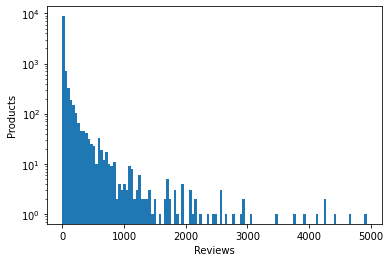

In [9]:
# Getting the review count for each product
X = df["drugName"].value_counts()

# Plotting the histogram 
figure=plt.figure(1)
plt.hist(X, bins=120, log=True)
plt.xlabel('Reviews')
plt.ylabel('Products')
plt.show()


As we can see above, most of the products have reviews in the first bin and displaying heterogeneous 
distribution.Next we are going to explore the rating column,if any bias towards positive or negative
sentiment is present.For accurate analysis and prediction ,we need to have a balanced dataset.


In [11]:
# Counting the frequency of each value in satisfaction column
df["rating"].value_counts()

#there are some outliers like rating is 12, and 20 , total 3 rows like that so removing them
df.drop(df[(df['rating'] ==12) | (df['rating'] == 20)].index, inplace=True)
df["rating"].value_counts()

10    179542
2     110162
8      88195
6      60308
4      42008
9      36708
1      28918
7      12547
5      10723
3       8718
Name: rating, dtype: int64

In [12]:
# Counting the frequency of each value,provides relative frequencies instead of the absolute.
df["rating"].value_counts(normalize=True)


10    0.310718
2     0.190648
8     0.152632
6     0.104370
4     0.072700
9     0.063527
1     0.050046
7     0.021714
5     0.018557
3     0.015088
Name: rating, dtype: float64


Lets put the review as positive or negative, given the rating distribution is unbalanced.Rating with 8 or 
above value will be considered as positive and 7 and below will be negative.We will create a new column 
`sentiment` in the dataset which will return 1 or 0 depending upon the given condition in the code.


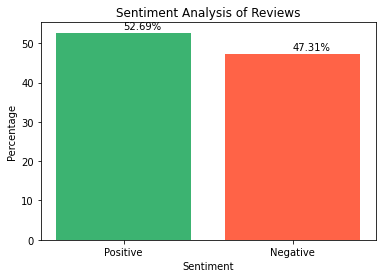

,uniqueID,drugName,review,rating,sentiment
0,206461,Valsartan,"""It has no side effect, I take it in combinati...",9,1
1,95260,Guanfacine,"""My son is halfway through his fourth week of ...",8,1
2,92703,Lybrel,"""I used to take another oral contraceptive, wh...",5,0
3,138000,Ortho Evra,"""This is my first time using any form of birth...",8,1
4,35696,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9,1


In [13]:

# Associating the sentiment based on the satisfaction rating and storing in a new column
#poitive sentiment =1 and negative sentiment =0
df["sentiment"] = [int(x >=8 ) for x in df["rating"].to_list()]
# Calculating the percentages of each sentiment 
pos = len(df[df["sentiment"]==1])
neg = len(df[df["sentiment"]==0])
tot = len(df)

# Calculating the percentages of each sentiment
pos_percentage = round(pos/tot*100, 2)
neg_percentage = round(neg/tot*100, 2)

# Creatinging the bar graph
sentiments = ['Positive', 'Negative']
percentages = [pos_percentage, neg_percentage]
colors = ['mediumseagreen', 'tomato']
plt.bar(sentiments, percentages, color=colors)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis of Reviews')

# Adding percentages above each bar
for i, percentage in enumerate(percentages):
    plt.text(i, percentage+1, str(percentage)+'%')

# Displaying the bar graph
plt.show()
df.head()




Since now , we have obtained relatively balanced dataset ,we can proceed with further analysis.For that lets take a drug (lotronex) and print its review and rating.


In [14]:
#Let's now have a look at the text pieces to see how we can process them
#As an example, we can take a specific product and print its review texts.

drug_name = 'lotronex'
# Create a new data frame with only that product
dfcalendar = df[df["drugName"]==drug_name].copy()
# Print the first three reviews
print("Review #1: " + dfcalendar.iloc[0]["review"])
print("Rating #1: " + str(dfcalendar.iloc[0]["rating"]))
print("----------")
print("Review #2: " + dfcalendar.iloc[1]["review"])
print("Rating #2: " + str(dfcalendar.iloc[1]["rating"]))
print("----------")
print("Review #3: " + dfcalendar.iloc[2]["review"])
print("Rating #3: " + str(dfcalendar.iloc[2]["rating"]))

Review #1: Ever since I had gallbladder removed I have had IBSD severely.  Lotronox has been a life saver.  However, now since taking it for over 10 years I have developed hive and rashes when taking it.  Hives are really bad.  So I had to stop.  Nothing else works as well as lotronex.  I wish I could go back to it but the hives has gotten so bad.  No other side effects for the 10+ years I was on it.  Not sure if anyone else has had this experience, but thought I should let you know. 
Rating #1: 10
----------
Review #2: It took awhile to get the right dose but after a few months I seem to be great on one half of a .05 mg tablet every other day. I try and make good food choices and drink plenty of water. I write down when I take the medicine and when I have a BM. This way I can back off if I need to to make sure I'm not getting C. (haven't had to do that since the first few weeks). Keep track of how much you take when you take it and your BM's. You think you'll remember but you won't. Y


We have observed different type of text, style, length and words, so in the next section,first we are
going to remove the stopwords which are very commom ,has no significance and contribution in our analysis.
Then we will see words that are common in the reviews with their frequency and importance in our text using Worldcloud.


In [16]:

from nltk.corpus import stopwords # removing common stopwords 
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

import numpy as np

def remove_stopwords(text):
    if isinstance(text, str):  # Checking if the value is a string
        # Tokenize the text into individual words
        words = text.split()
        
        # Removing stopwords from the tokenized words
        filtered_words = [word for word in words if word.lower() not in stop_words]
        
        # Reconstructing the filtered words into a single string
        filtered_text = ' '.join(filtered_words)
        
        return filtered_text
    else:
        return np.nan  # Return NaN for non-string values

df['review'] = df['review'].apply(remove_stopwords)
df.head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lithium\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,uniqueID,drugName,review,rating,sentiment
0,206461,Valsartan,"""It side effect, take combination Bystolic 5 M...",9,1
1,95260,Guanfacine,"""My son halfway fourth week Intuniv. became co...",8,1
2,92703,Lybrel,"""I used take another oral contraceptive, 21 pi...",5,0
3,138000,Ortho Evra,"""This first time using form birth control. I&#...",8,1
4,35696,Buprenorphine / naloxone,"""Suboxone completely turned life around. feel ...",9,1


In [17]:
#import matplotlib.pyplot as plt
from wordcloud import WordCloud

sample_size = 100000  # taking random 100000 rows 
sampled_reviews = df.sample(n=sample_size, random_state=42)['review']  # Perform random sampling on the DataFrame


# Concatenate all the reviews into a single string
text = " ".join(sampled_reviews .astype(str).tolist())


In [18]:
# Create a WordCloud object
wordcloud = WordCloud().generate(text)


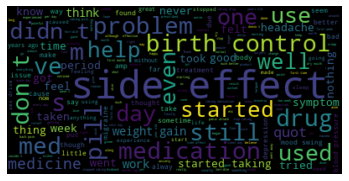

In [19]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



The dimension of our dataset is quite large so we have taken random 100000 rows to analyse the words
in the text so that we can build a simple classifier.We are going to use one-hot encoding in which our 
category of words(defined below in dictionary) will be represented by binary vector of zeros and a single 
one and hence the appearance of these words in the review will be checked.


In [20]:
#Building a simple classifier

from tensorflow.keras.preprocessing.text import Tokenizer
dfnew = df.copy(deep=True)
texts = dfcalendar["review"].to_list()

# Define our tokenizer
token = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

# Define our dictionary
token.word_index = {"good":1, "wonderful":2, "great":3, "stopped":4, "never":5, "discontinued":6}
# apply token to texts
sequences = token.texts_to_sequences(dfnew["review"].astype(str))

# Store the sequences of each review in a new column
dfnew['sequences'] = sequences
# Iterate over elements of dictionary token.word_index
for key,val in token.word_index.items():
    # Create a new column based on that, if val is in the sequence add 1, 0 otherwise
    dfnew[key] = [int(val in x) for x in dfnew["sequences"].to_list()]
dfnew.head()

,uniqueID,drugName,review,rating,sentiment,sequences,good,wonderful,great,stopped,never,discontinued
0,206461,Valsartan,"""It side effect, take combination Bystolic 5 M...",9,1,[],0,0,0,0,0,0
1,95260,Guanfacine,"""My son halfway fourth week Intuniv. became co...",8,1,[1],1,0,0,0,0,0
2,92703,Lybrel,"""I used take another oral contraceptive, 21 pi...",5,0,[],0,0,0,0,0,0
3,138000,Ortho Evra,"""This first time using form birth control. I&#...",8,1,[5],0,0,0,0,1,0
4,35696,Buprenorphine / naloxone,"""Suboxone completely turned life around. feel ...",9,1,"[1, 3]",1,0,1,0,0,0


In [21]:
for key in token.word_index.keys():
    # Calculate in how many reviews the word appears.
    num = dfnew[key].sum()
    # Calculate the percentage
    pctg = round(num/len(dfnew[key])*100,2)
    print(key,'appears in', num, 'Reviews (', pctg, '%)')

good appears in 50555 Reviews ( 8.75 %)
wonderful appears in 6658 Reviews ( 1.15 %)
great appears in 45935 Reviews ( 7.95 %)
stopped appears in 31844 Reviews ( 5.51 %)
never appears in 51243 Reviews ( 8.87 %)
discontinued appears in 2240 Reviews ( 0.39 %)



Above is the distribution of words in text. However this cannot give us a fair idea about positive and negative sentimnet.For example,if a review is `i dont feel good` ,here reviewer is not happy with the drug but because tokeniser splits the words of review so it might mislead us for a positive sentiment though it is clearly negative.So we need machine learning algorithm to predict the actual emotion.For that
we are going to split the dataset in two parts: Training and testing in the ratio 80%-20% respectively.


In [22]:
from sklearn.model_selection import train_test_split

X = dfnew[list(token.word_index.keys())].values
y = dfnew['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)
print("X_train:")
print(X_train)
print("y_train:")
print(y_train)

X_train:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
y_train:
[0 1 1 ... 1 1 0]



Now, lets build a classifier based on ANN using keras library,which consists of three main steps:

**a)Defining a model**: In this, architecture of the model,number and types of layers, activation function
  for neurons in specified.
  
**b)Training the model**: This involves feeding the training data to the model,adjusting the model's 
  parameters(weights and bias) ,providing optimising algorithm and loss function.
  
**c)Evaluation of Model**: Once trained, evaluating model's performance using test dataset.This step         calculates how well the model generalizes to unseen data.
 
So our ANN model below consists of sequential model with activation function "ReLU" to be used in the hidden layers of the neural network."ReLU" stands for Rectified Linear Unit,one hidden layers with 6 neurons and one output layer.


In [ ]:
#1. Model Definition 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session

# Clearing data from any ANN previous model
clear_session()

# Input dimenstion (Number of features)
input_dim = 6

model = Sequential()
model.add(layers.Dense(6, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [24]:
#training our Artificial Neural Network:
history = model.fit(X_train, y_train, epochs=12, verbose=True, validation_split=0.2, batch_size=500)

Epoch 1/12
740/740 [==============================] - 3s 3ms/step - loss: 0.6819 - accuracy: 0.5508 - val_loss: 0.6781 - val_accuracy: 0.5539
Epoch 2/12
740/740 [==============================] - 2s 3ms/step - loss: 0.6775 - accuracy: 0.5535 - val_loss: 0.6775 - val_accuracy: 0.5546
Epoch 3/12
740/740 [==============================] - 2s 3ms/step - loss: 0.6774 - accuracy: 0.5538 - val_loss: 0.6776 - val_accuracy: 0.5546
Epoch 4/12
740/740 [==============================] - 2s 3ms/step - loss: 0.6773 - accuracy: 0.5538 - val_loss: 0.6776 - val_accuracy: 0.5546
Epoch 5/12
740/740 [==============================] - 2s 3ms/step - loss: 0.6773 - accuracy: 0.5538 - val_loss: 0.6775 - val_accuracy: 0.5546
Epoch 6/12
740/740 [==============================] - 2s 3ms/step - loss: 0.6773 - accuracy: 0.5538 - val_loss: 0.6774 - val_accuracy: 0.5546
Epoch 7/12
740/740 [==============================] - 2s 3ms/step - loss: 0.6773 - accuracy: 0.5538 - val_loss: 0.6774 - val_accuracy: 0.5546
Epoch 

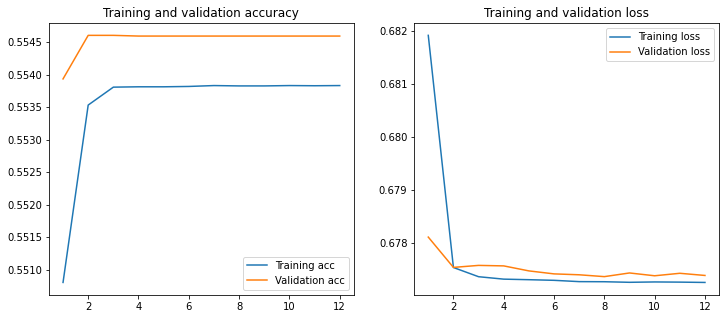

In [25]:
# Function for plotting the training & validation curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)


Our dataset is trained and the plot of training and validation curves above shows that the plots after 12 
epochs are quite similar so no problem of overfitting here so lets proceed with evaluation.


In [26]:
#3. Evaluation
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.5540
Testing Accuracy:  0.5541



The results obtained from above model are not very good,though there is no difference in training and testing accuracy but performance of the model can be improved. We have only used few words that might have limited the potential of our ANN model so now we are going to use tokensizer from keras which will use all words from reviews text and create a dictionary and sort it by frequency of words. We are expecting our model to perform better this time as number of input has increased.


In [27]:
#creating dictionary of words based on actual text

# Defining the tokenizer.
tokenizer1 = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', num_words = 1000)
# Convert the column reviews to a list of texts properly formatted
alltext = df["review"].astype(str).to_list()
# Extracting the dictionary of words from the text
tokenizer1.fit_on_texts(alltext)
# Creating a dataframe with the word count
dfwords = pd.DataFrame.from_dict(tokenizer1.word_counts, orient="index",columns=["frequency"])
# Showing the top 15 words
dfwords.sort_values(by="frequency", ascending=False).head(15)

,frequency
039,350546
i,275347
taking,177302
pain,170235
it,162842
day,159213
side,158292
take,148121
t,133270
effects,130242



In general, most frequently occuring words are common english words as we have seen above,so lets check if we got some significant words from text review,by checking words randomly in the middle.
 

In [28]:
# Showing the words between the 800th and 815th position.
dfwords.sort_values(by="frequency", ascending=False).iloc[700:720,:]

,frequency
normally,5172
knew,5171
yesterday,5156
focus,5149
supposed,5146
hungry,5143
child,5107
smoking,5091
suggested,5078
c,5052


In [29]:
# applying sequence vector, not counting 
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Transform training reviews into sequences:  
sequences = tokenizer1.texts_to_sequences(df["review"].astype(str).to_list())
padded = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')
df["sequences"] = list(padded)
df.head()


,uniqueID,drugName,review,rating,sentiment,sequences
0,206461,Valsartan,"""It side effect, take combination Bystolic 5 M...",9,1,"[5, 7, 109, 8, 773, 47, 69, 0, 0, 0, 0, 0, 0, ..."
1,95260,Guanfacine,"""My son halfway fourth week Intuniv. became co...",8,1,"[318, 475, 35, 327, 850, 260, 85, 35, 16, 3, 7..."
2,92703,Lybrel,"""I used take another oral contraceptive, 21 pi...",5,0,"[2, 87, 8, 171, 822, 33, 604, 204, 288, 167, 4..."
3,138000,Ortho Evra,"""This first time using form birth control. I&#...",8,1,"[101, 19, 17, 100, 633, 123, 81, 2, 1, 29, 577..."
4,35696,Buprenorphine / naloxone,"""Suboxone completely turned life around. feel ...",9,1,"[228, 779, 43, 177, 22, 2, 1, 29, 409, 169, 83..."



We have applied sequence vector above, rather than counting the occurence of words in the text.This will 
solve the complexities of natural language and our ANN model would be able to distinguish between actual 
positive or actual negative sentiment and performance of the model will increase.Also we have applied padding to make our text length homogeneous so thet our ANN Model would have fixed size of all reviews.In the next section, we are going to define and train our ANN model.


In [30]:
# Converting to list and then to numpy array
X1 = np.array(df["sequences"].to_list())
y1 = np.array(df['sentiment'].to_list())

# Use the train_test_split from the sklearn library
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=28)

In [31]:
from tensorflow.keras.layers import Embedding

# Clear the session of previous ANN
clear_session()

#1. Model Definition
model1 = Sequential()
model1.add(layers.Embedding(input_dim=1000, output_dim=32, input_length=50))
model1.add(layers.Flatten())
model1.add(layers.Dense(6, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            32000     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 6)                 9606      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 41,613
Trainable params: 41,613
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
740/740 [==============================] - 9s 10ms/step - loss: 0.5440 - accuracy: 0.7174 - val_loss: 0.5042 - val_accuracy: 0.7526
Epoch 2/12
740/740 [==============================] - 7s 10ms/step - loss: 0.4985 - accuracy: 0.7559 - val_loss: 0.4989 - val_accuracy: 0.7567
Epoch 3/12
740/740 [==============================] - 7s 10ms/step - loss: 0.4869 - accuracy: 0.7633 - val_loss: 0.4982 - val_accuracy: 0.7578
Epoch 4/12
740/740 [==============================] - 8s 10ms/step - loss: 0.4761 - accuracy: 0.7698 - val_loss: 0.4996 - val_accuracy: 0.7577
Epoch 5/12
740/740 [==============================] - 8s 10ms/step - loss: 0.4664 - accuracy: 0.7764 - val_loss: 0.4999 - val_accuracy: 0.7576
Epoch 6/12
740/740 [==============================] - 8s 10ms/step - loss: 0.4579 - accuracy: 0.7817 - val_loss: 0.5022 - val_accuracy: 0.7575
Epoch 7/12
740/740 [==============================] - 8s 10ms/step - loss: 0.4510 - accuracy: 0.7864 - val_loss: 0.5038 - val_accuracy: 0.7584

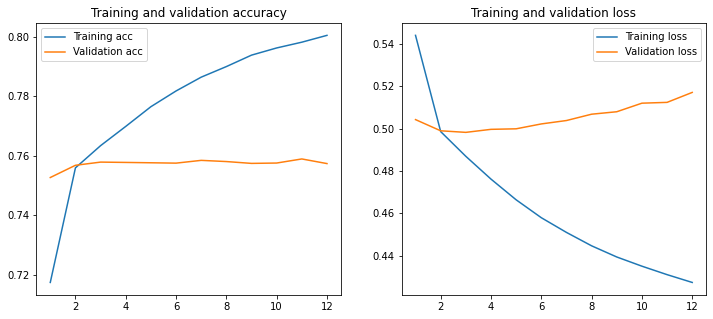

In [32]:
# 2. Training the Model
history = model1.fit(X1_train, y1_train, epochs=12, verbose=True, validation_split=0.2, batch_size=500)
plot_history(history)



The plots obtained above are different from simple classifier,but positive part is,performance of the model
has increased.This clearly indicates that more words and complex structure can make ANN model good for sentiment analysis.However our plot shows the signs of overfitting as training curve is going up.The performance has increased but there is a gap in training and testing accuracies as seen in below accuracies.


In [33]:
# 3. Evaluation of Model
loss, accuracy = model1.evaluate(X1_train, y1_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X1_test, y1_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7995
Testing Accuracy:  0.7568



In the next section, we are going to make few changes in order to reduce the overfitting.First we are going to increase the length of the sequence and add two dense (fully connected) layers with the activation function 'tanh' to a Keras model.We are also going to increase the number of neurons and finally we will replace flatten() with GlobalAveragePooling1D() to reduce the number of parameters.


In [34]:
#Trying max len=100 and diff parameters, lets see , if accuracy of the model can be improved
sequences = tokenizer1.texts_to_sequences(df["review"].astype(str).to_list())
padded1 = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
df["sequences"] = list(padded1)

X2 = np.array(df["sequences"].to_list())
y2 = np.array(df['sentiment'].to_list())

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=28)


In [35]:
# Clear the session of any previous ANN
clear_session()

# 1. Definition
model2 = Sequential()
model2.add(layers.Embedding(input_dim=1000, output_dim=32, input_length=100))
model2.add(layers.GlobalAveragePooling1D())
model2.add(layers.Dense(32, activation='tanh'))
model2.add(layers.Dense(16, activation='tanh'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           32000     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
____________________________________________________

Epoch 1/12
740/740 [==============================] - 12s 15ms/step - loss: 0.5529 - accuracy: 0.7116 - val_loss: 0.5238 - val_accuracy: 0.7477
Epoch 2/12
740/740 [==============================] - 11s 15ms/step - loss: 0.5240 - accuracy: 0.7393 - val_loss: 0.5225 - val_accuracy: 0.7438
Epoch 3/12
740/740 [==============================] - 11s 15ms/step - loss: 0.5221 - accuracy: 0.7409 - val_loss: 0.5217 - val_accuracy: 0.7423
Epoch 4/12
740/740 [==============================] - 11s 15ms/step - loss: 0.5206 - accuracy: 0.7411 - val_loss: 0.5195 - val_accuracy: 0.7466
Epoch 5/12
740/740 [==============================] - 11s 15ms/step - loss: 0.5199 - accuracy: 0.7414 - val_loss: 0.5198 - val_accuracy: 0.7301
Epoch 6/12
740/740 [==============================] - 11s 15ms/step - loss: 0.5196 - accuracy: 0.7410 - val_loss: 0.5199 - val_accuracy: 0.7301
Epoch 7/12
740/740 [==============================] - 11s 15ms/step - loss: 0.5194 - accuracy: 0.7418 - val_loss: 0.5192 - val_accuracy:

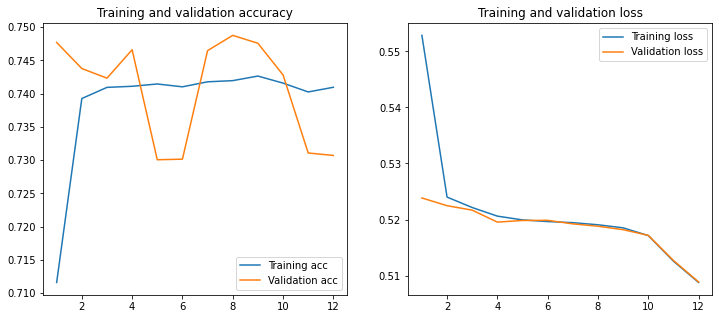

In [36]:
# 2. Training
history2 = model2.fit(X2_train, y2_train, epochs=12, verbose=True, validation_split=0.2, batch_size=500)
plot_history(history2)

# 3. Evaluation
loss, accuracy = model2.evaluate(X2_train, y2_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X2_test, y2_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


After making changes mentioned above,Training accuracy has decreased slightly but gap between testing and training has gone,that suggests our model has acheived similar performance on both training and testing datasets.This indicates our model has generalized well and it is not overfitting to training data and model is reliable.


### Result

After all the above analysis, we can sum up the result as:

**Simple classifier**: Training Accuracy:0.5540 and Testing Accuracy:0.5541

**ANN Model with 'relu'activation function**:Training Accuracy:0.7995 and Testing Accuracy:0.7568

**ANN Model with more layers and 'tanh' activation function**:Training Accuracy: 0.7333 and Testing Accuracy: 0.7305



### Conclusion

Overall, the ANN models outperformed the simple classifier, demonstrating the ability of neural networks to capture more complex patterns in the data. The model with 'relu' activation achieved the highest accuracy, while the model with 'tanh' activation and more layers showed slightly lower accuracy but with reduced overfitting.

Considering these results, the ANN model with 'relu' activation function appears to be the most effective in this analysis, achieving the highest accuracy on both the training and testing datasets. However, the choice of the best model ultimately depends on the specific requirements of the application and the trade-off between accuracy and model complexity.This analysis can be helpful not just for patients but also for doctors and pharma companies to check the reviews on various drugs in the market and make informed decision.

